In [1]:
import rasterio
from rasterio.mask import mask
from shapely.geometry import box
import numpy as np
import pandas as pd

In [2]:
# check if bahia exist in the geoboundries

import geopandas as gpd

# Path to the geojson file
boundary_file = r"D:\NU\semester_5\data_analysis\project\edited_project\geoBoundaries-BRA-ADM1-all\geoBoundaries-BRA-ADM1.geojson"

# Load the GeoJSON file
brazil_boundaries = gpd.read_file(boundary_file)

city_name_column = "shapeName"

bahia_boundary = brazil_boundaries[brazil_boundaries[city_name_column] == "Bahia"]

# Check if the boundary is found
if not bahia_boundary.empty:
    print("Bahia boundary found!")
else:
    raise ValueError("Bahia boundary not found. Check the city name or column.")

bahia_boundary.to_file("bahia_boundary.geojson", driver="GeoJSON")

# Print the coordinates of the boundary (or process further as needed)
print(bahia_boundary)

Bahia boundary found!
   shapeName shapeISO                  shapeID shapeGroup shapeType  \
15     Bahia    BR-BA  14911670B19428866735507        BRA      ADM1   

                                             geometry  
15  POLYGON ((-41.36067 -8.77411, -41.36371 -8.775...  


In [6]:
# Filepaths

# raster_file = r"D:\NU\semester_5\data_analysis\project\edited_project\SVDNB_npp_20200101-20200131_00N060W_vcmcfg_v10_c202002111500\SVDNB_npp_20200101-20200131_00N060W_vcmcfg_v10_c202002111500.avg_rade9h.tif"
# raster_file = r"D:\NU\semester_5\data_analysis\project\edited_project\SVDNB_npp_20200201-20200229_00N060W_vcmcfg_v10_c202003021200\SVDNB_npp_20200201-20200229_00N060W_vcmcfg_v10_c202003021200.avg_rade9h.tif"
raster_file = r"D:\NU\semester_5\data_analysis\project\edited_project\SVDNB_npp_20200301-20200331_00N060W_vcmcfg_v10_c202007042300\SVDNB_npp_20200301-20200331_00N060W_vcmcfg_v10_c202007042300.avg_rade9h.tif"

bahia_boundary_file = r"D:\NU\semester_5\data_analysis\project\edited_project\bahia_boundary.geojson"

# output_csv = r"D:\NU\semester_5\data_analysis\project\edited_project\viirs_bahia_1_dataset.csv"
# output_csv = r"D:\NU\semester_5\data_analysis\project\edited_project\viirs_bahia_2_dataset.csv"
output_csv = r"D:\NU\semester_5\data_analysis\project\edited_project\viirs_bahia_3_dataset.csv"

# Load the Brasília boundary
bahia = gpd.read_file(bahia_boundary_file)
bahia = bahia.to_crs(epsg=4326)

# Open the VIIRS raster file
with rasterio.open(raster_file) as src:
    raster_bounds = box(*src.bounds)
    print("Raster Bounds:", src.bounds)
    print("bahia Bounds:", bahia.total_bounds)

    if not raster_bounds.intersects(bahia.unary_union):
        raise ValueError("bahia's boundary does not overlap with the raster extent.")

    # Clip the VIIRS raster using Brasília boundary
    bahia_geom_list = [feature["geometry"] for feature in bahia.__geo_interface__["features"]]
    clipped_raster, clipped_transform = mask(src, bahia_geom_list, crop=True)

# Extract Raster Values for Brasília
light_intensity = clipped_raster[0]
rows, cols = np.where(~np.isnan(light_intensity))
values = light_intensity[rows, cols]
x_coords, y_coords = rasterio.transform.xy(clipped_transform, rows, cols)

# Create a DataFrame
data = pd.DataFrame({
    'longitude': x_coords,
    'latitude': y_coords,
    'light_intensity': values
})

# Save the data to a CSV file
data.to_csv(output_csv, index=False)
print(f"Extracted data for bahia saved to {output_csv}")

Raster Bounds: BoundingBox(left=-60.00208333335, bottom=-64.99791718665, right=59.99791762665001, top=0.00208333335)
bahia Bounds: [-46.60349344 -18.31554034 -37.35288249  -8.56929603]


C:\Users\PC\AppData\Local\Temp\ipykernel_19600\2750384159.py:23: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  if not raster_bounds.intersects(bahia.unary_union):


Extracted data for bahia saved to D:\NU\semester_5\data_analysis\project\edited_project\viirs_bahia_3_dataset.csv


In [1]:
import pandas as pd

In [2]:
output_csv = r"D:\NU\semester_5\data_analysis\project\edited_project\viirs_bahia_1_dataset.csv"

df = pd.read_csv(output_csv)
df.head()

,longitude,latitude,light_intensity
0,-46.604167,-8.570833,0.0
1,-46.600000,-8.570833,0.0
2,-46.595833,-8.570833,0.0
3,-46.591667,-8.570833,0.0
4,-46.587500,-8.570833,0.0


array([[<Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'latitude'}>],
       [<Axes: title={'center': 'light_intensity'}>, <Axes: >]],
      dtype=object)

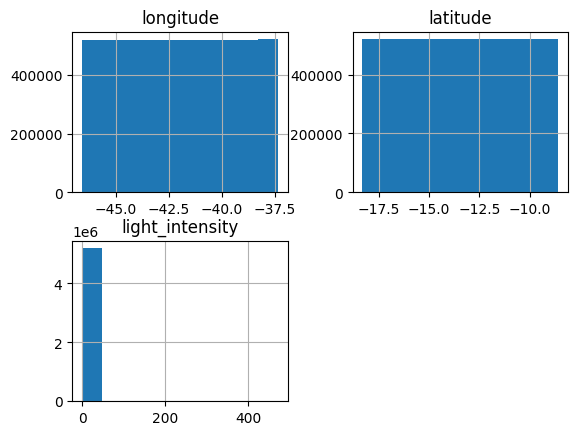

In [3]:
df.hist()
